In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np
import os
import segyio
import glob

import scipy as sp

from scipy.sparse.linalg import LinearOperator, cg, lsqr

import pylops
from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.optimization.sparsity  import *

# EXPERIMENT PARAMS
from pyfrac.hydrafrac.acquisition import recgeom,rec2das_datatrnsfrm,dasgeom

# LOCATION
from pyfrac.pseudodas.receiveroperators import cubePDoperator
from pyfrac.modelling.kirchhoff import Kirchhoff
from pyfrac.locationsolvers.localisationutils import get_max_locs

# VISUALISATION
from pyfrac.visualisation.traceviz import traceimage, wiggleplot, multiwiggleplot
from pyfrac.visualisation.eventimages import locimage3d
from pyfrac.visualisation.plotting_support import explode_volume

%matplotlib inline
import matplotlib.pyplot as plt

In [5]:
local_modpath = '/home/birniece/Documents/data/ANPERC_Lab/STYLOLITES/StyloliteModels'

seispath = '/home/birniece/Documents/Projects/MicroseismicModelling/ShaheenTransfers/INCOMING/Stylolites/outputs/su'
modpath ='/home/birniece/Documents/Projects/MicroseismicModelling/ShaheenTransfers/OUTGOING/Stylolites/inputs/StyloliteModels/'
figpath = './Figures/StyloliteWaveforms/'

# MODELS
    "NX" : "460",
    "NY" : "460",
    "NZ" : "460",

In [23]:
nx = ny = nz = 460
dx = dy = dz = 0.001
abs_bounds = 30

x, y, z = np.arange(nx-abs_bounds)*dx, np.arange(ny-abs_bounds)*dy, np.arange(nz-abs_bounds)*dz
v0 = 5260



In [13]:
mod = np.fromfile(os.path.join(modpath,'Homogeneous.vp'),dtype='float32').reshape([nx,ny,nz])

In [14]:
mod.shape
mod_nobounds = mod[abs_bounds:-abs_bounds,abs_bounds:-abs_bounds,abs_bounds:-abs_bounds]

(460, 460, 460)

In [21]:
def plot_XYslice(vp_mod_sty, abs_bounds):
    fig,ax = plt.subplots(1,1,figsize=[5,5])
    c = ax.imshow(vp_mod_sty[abs_bounds:-abs_bounds,abs_bounds:-abs_bounds,0].T, 
                  aspect='auto', cmap='copper', vmax=np.max(vp_mod_sty), vmin=np.max(vp_mod_sty)*0.7,
                  extent=[0,40,40,0],
                 )
    ax.set_ylabel('y [cm]'); ax.set_xlabel('x [cm]');
    return fig

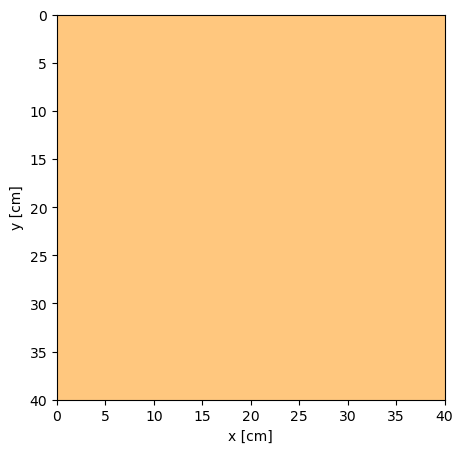

In [22]:
fig = plot_XYslice(mod_nobounds, abs_bounds=0)


In [24]:
# RECEIVERS
recs = np.loadtxt('/home/birniece/Documents/Projects/MicroseismicModelling/ShaheenTransfers/OUTGOING/Stylolites/inputs/gridded_recs.dat').T
recs = recs - (abs_bounds*dx)
nr = recs.shape[1]
nr_per_face = nr//6
print(nr)

150


# SOURCE LOCATION

In [ ]:
def read_seis(seisfile, nr):
    # s_wave_file = os.path.join(data_path,'test.bin.curl')
    seis_flat = np.loadtxt(seisfile)

    # determine number of timesamples and ensure it saved fully
    nt = int(seis_flat.shape[0] / nr)
    try:
        seis_flat.reshape((nr, nt))
    except:
        print('Not good dims \n nt:%i nr:%i \n vz flat:%i' % (nt, nr, seis_flat.shape[0]))

    # Resample to 2D
    seis = seis_flat[:nt * nr].reshape((nr, nt))
    return seis

In [ ]:

model_files = glob.glob(local_modpath+'/*pc90.vp')
exp_list = [m.split('/')[-1][:-8] for m in model_files]
exp_list

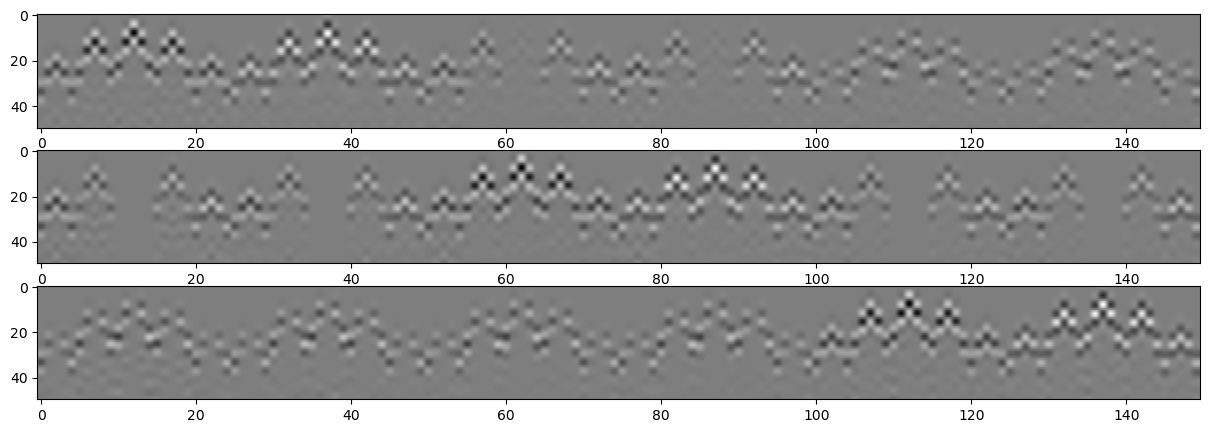

In [7]:
npzfile = 'StylolitesExp_2mm_5r_3sty_80perc.npz'

clean_vx = np.load(os.path.join(datadir,npzfile))['vx']
clean_vy = np.load(os.path.join(datadir,npzfile))['vy']
clean_vz = np.load(os.path.join(datadir,npzfile))['vz']
clean_div = np.load(os.path.join(datadir,npzfile))['p']

recs = np.load(os.path.join(datadir,npzfile))['recs']  # for 2mm

fig,axs = plt.subplots(3,1,figsize=[15,5])
axs[0].imshow(clean_vx[:,50:100].T, aspect='auto',cmap='binary_r')
axs[1].imshow(clean_vy[:,50:100].T, aspect='auto',cmap='binary_r')
axs[2].imshow(clean_vz[:,50:100].T, aspect='auto',cmap='binary_r')

Text(0.5, 1.0, 'Point Receivers')

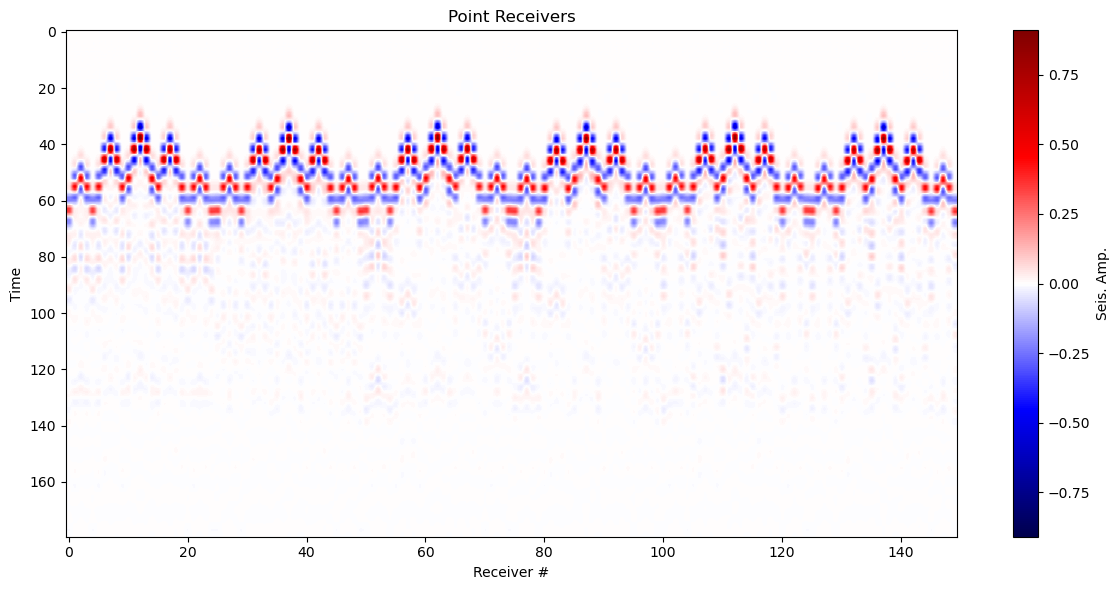

In [8]:
# Make the one for location as perpendicular to each face
data_for_loc = np.zeros_like(clean_vx)
data_for_loc[:25]    = -1*clean_vx[:25]
data_for_loc[25:50]  =    clean_vx[25:50]
data_for_loc[50:100] = -1*clean_vy[50:100]
data_for_loc[75:100] =    clean_vy[75:100]
data_for_loc[-50:]   = -1*clean_vz[-50:]
data_for_loc[-25:]   =    clean_vz[-25:]

# data_for_loc = clean_div

t_shift = 20
data_for_loc = data_for_loc[:,t_shift:]
data_for_loc = data_for_loc/np.max(abs(data_for_loc))

fig,ax = traceimage(data_for_loc, climQ=99.99)
ax.set_title('Point Receivers')

# OPERATORS

/home/birniece/miniconda3/envs/pyfrac/lib/python3.9/site-packages/pylops/utils/wavelets.py:21: UserWarning: one sample removed from time axis...
  warnings.warn("one sample removed from time axis...")


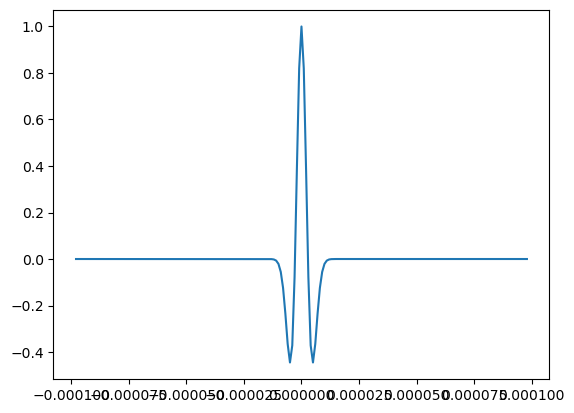

In [9]:
# TIME AXIS AND WAVELET
dt = 1e-6
nt = data_for_loc.shape[1]
t = np.arange(nt)*dt

fc = 80000
wav, wavt, wavc = ricker(t[:100], f0=fc)
plt.plot(wavt,wav)

In [10]:
# Reduce modelling dims for inversion
dx = dy = dz = 0.005  # 1mm
dimlims = 0.4 
nx = ny = nz = int(dimlims/dx) 
x, y, z = np.arange(nx)*dx, np.arange(ny)*dy, np.arange(nz)*dz
v0 = 5260

In [11]:
# INITIALISE OPERATOR
Op = Kirchhoff(z=z, 
               x=x, 
               y=y, 
               t=t, 
               srcs=recs[:, :1], 
               recs=recs, 
               vel=v0, 
               wav=wav, 
               wavcenter=wavc, 
               mode='analytic', 
               engine='numba')

# check operator with dottest
_ = dottest(Op, verb=True)

/home/birniece/Documents/Projects/MicroseismicModelling/MicroseismicProcessing/pyfrac/imaging/kirchhoff.py:261: FutureWarning: A new implementation of Kirchhoff is provided in v2.1.0. This currently affects only the inner working of the operator, end-users can continue using the operator in the same way. Nevertheless, it is now recommended to providethe variables trav (and amp) as a tuples containing the traveltime (and amplitude) tables for sources and receivers separately. This behaviour will eventually become default in version v3.0.0.
  warnings.warn(


Dot test passed, v^H(Opu)=14703.945696582003 - u^H(Op^Hv)=14703.945696581806


Text(0.5, 1.0, 'Point Receivers')

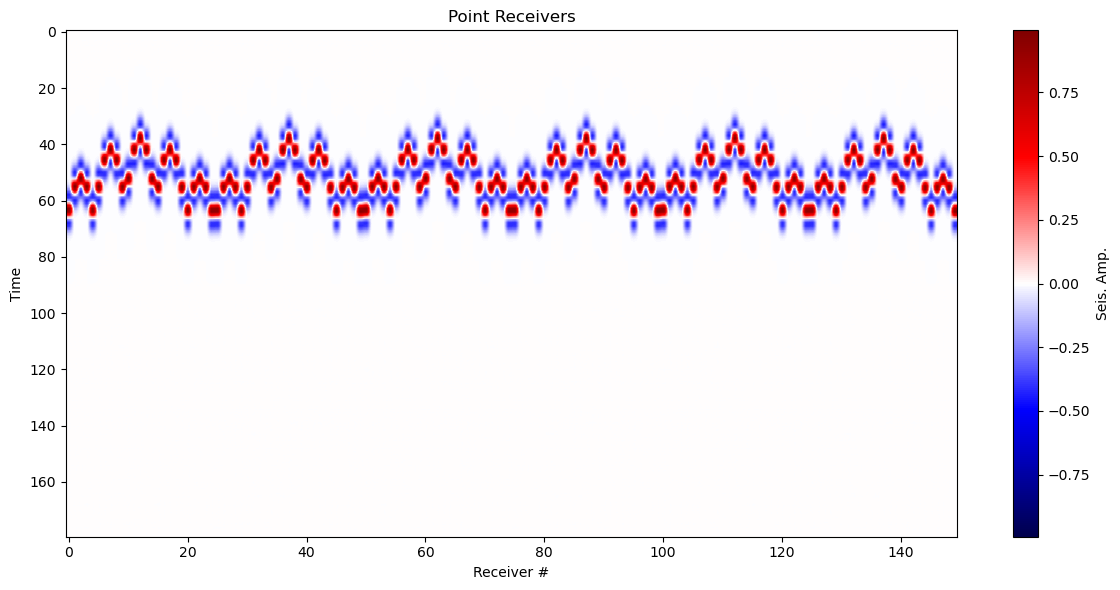

In [12]:
sx, sy, sz = [nx//2, ny//2, nz//2]
microseismic = np.zeros((nx, ny, nz))
microseismic[sx, sy, sz] = 1.

frwddata_1d = Op @ microseismic.flatten().squeeze()
frwddata  = frwddata_1d.reshape(nr,nt)
fig,ax = traceimage(frwddata, climQ=99.99)
ax.set_title('Point Receivers')

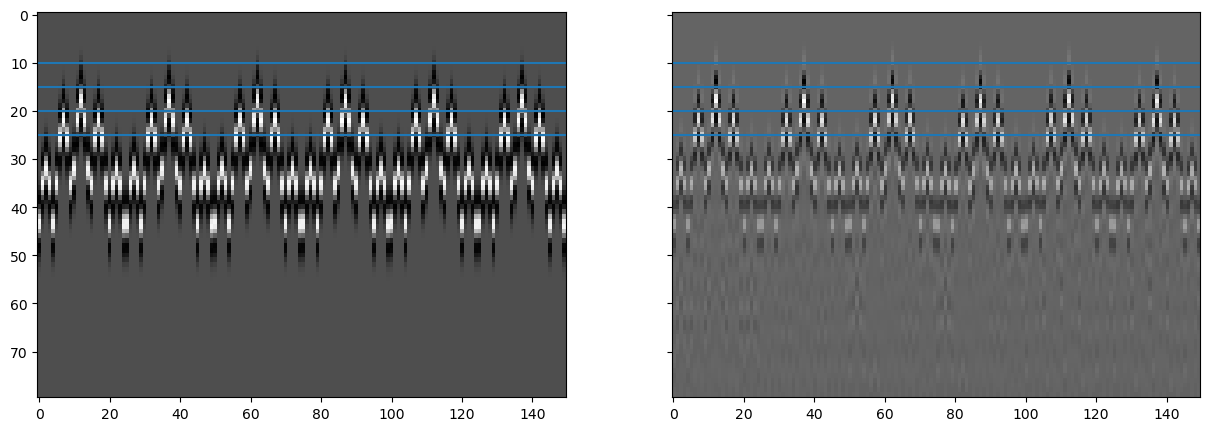

In [13]:
fig,axs = plt.subplots(1,2,figsize=[15,5], sharey=True)
axs[0].imshow(frwddata[:,20:100].T, aspect='auto',cmap='binary_r')
axs[1].imshow(data_for_loc[:,20:100].T, aspect='auto',cmap='binary_r')
for ax in axs: ax.axhline(10)
for ax in axs: ax.axhline(15)
for ax in axs: ax.axhline(20)
for ax in axs: ax.axhline(25)

Text(0.5, 1.0, 'Point Receivers')

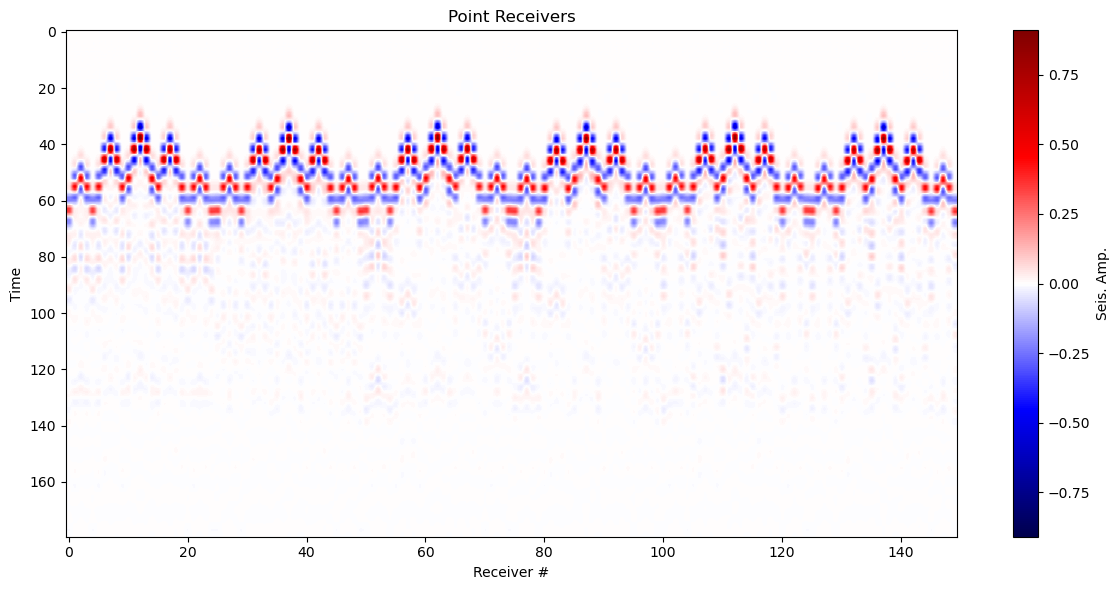

In [14]:
fig,ax = traceimage(data_for_loc, climQ=99.99)
ax.set_title('Point Receivers')

Migration-Based Hypo Center: [39.8 39.8 39.8]


/home/birniece/Documents/Projects/MicroseismicModelling/MicroseismicProcessing/pyfrac/visualisation/eventimages.py:10: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


Text(0.5, 0.98, 'Mig.: Frwd Data')

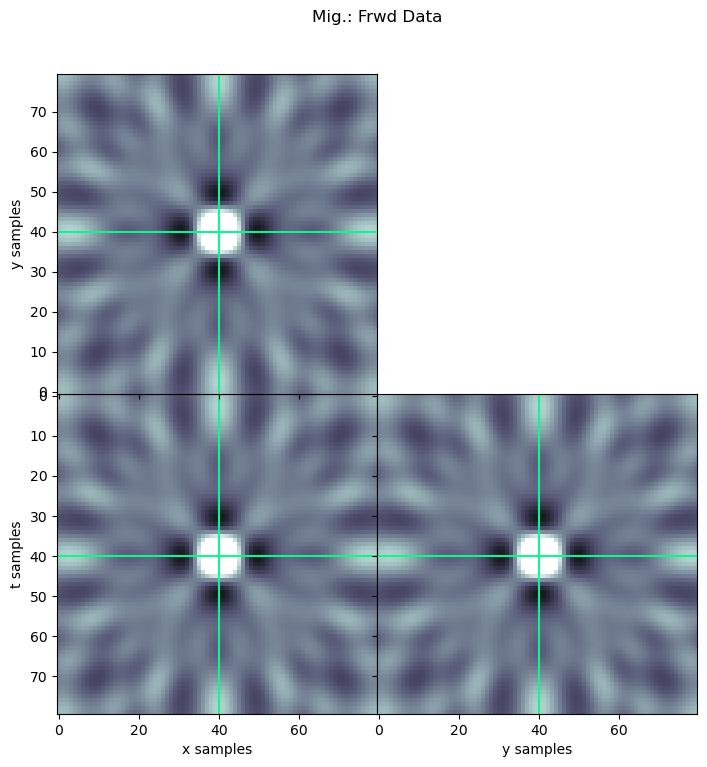

In [15]:
migrated = (Op.H @ frwddata).reshape(nx,ny,nz)
hc, hcs =  get_max_locs(migrated, n_max=10, rem_edge=False)
print('Migration-Based Hypo Center:',hc.flatten())
fig,axs = locimage3d(migrated,sx, sy)
fig.suptitle('Mig.: Frwd Data')

Migration-Based Hypo Center: [40.2 39.8 39.8]


Text(0.5, 0.98, 'Mig.: Clean')

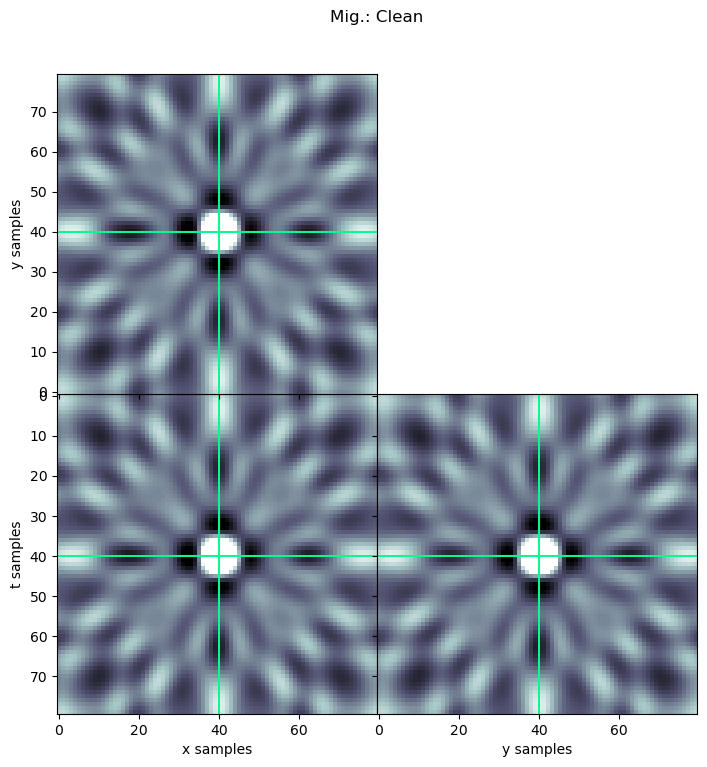

In [16]:
migrated = (Op.H @ data_for_loc).reshape(nx,ny,nz)
hc, hcs =  get_max_locs(migrated, n_max=10, rem_edge=False)
print('Migration-Based Hypo Center:',hc.flatten())
fig,axs = locimage3d(migrated,sx, sy)
fig.suptitle('Mig.: Clean')

 
LSQR            Least-squares solution of  Ax = b
The matrix A has 27000 rows and 512000 columns
damp = 0.00000000000000e+00   calc_var =        0
atol = 1.00e-06                 conlim = 1.00e+08
btol = 1.00e-06               iter_lim =      100
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   1.414e+01  1.414e+01    1.0e+00  2.8e+01
     1  5.69824e-05   9.679e+00  9.679e+00    6.8e-01  5.7e-01   5.5e+02  1.0e+00
     2  8.33799e-05   7.198e+00  7.198e+00    5.1e-01  4.2e-01   7.8e+02  2.4e+00
     3  9.70986e-05   6.033e+00  6.033e+00    4.3e-01  2.4e-01   1.1e+03  4.0e+00
     4  9.18239e-05   5.238e+00  5.238e+00    3.7e-01  2.1e-01   1.2e+03  5.6e+00
     5  9.68063e-05   4.635e+00  4.635e+00    3.3e-01  1.7e-01   1.4e+03  7.6e+00
     6  8.06106e-05   4.012e+00  4.012e+00    2.8e-01  1.2e-01   1.6e+03  9.9e+00
     7  6.50926e-05   3.607e+00  3.607e+00    2.6e-01  1.1e-01   1.7e+03  1.2e+01
     8  5.85856e-05   3.379e+00

Text(0.5, 0.98, 'LSQR Loc.: 3 @ 2mm \n Computed Hypo Center: [0.20,0.20,0.20]')

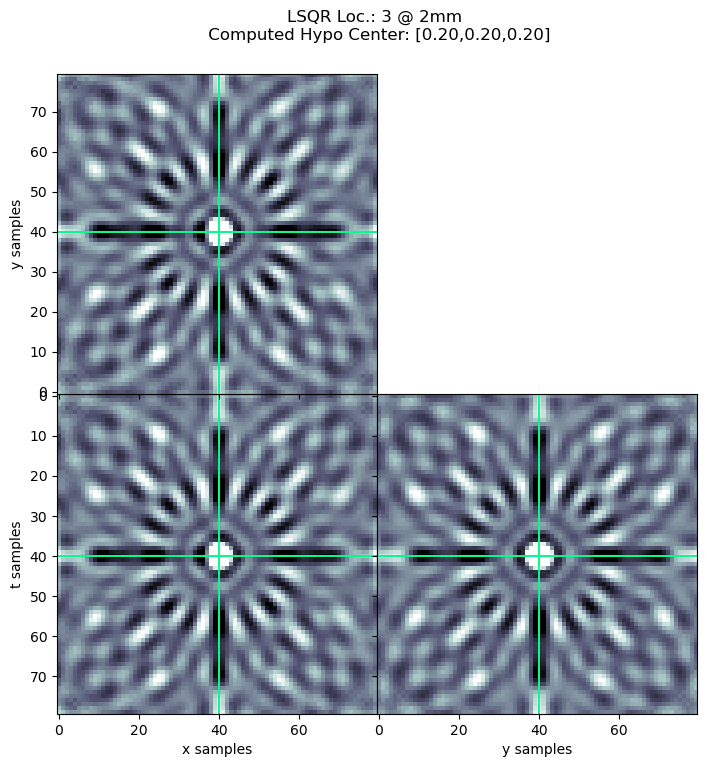

In [17]:
inv = (lsqr(Op, data_for_loc.ravel(), iter_lim=100, show=True)[0]).reshape(nx,ny,nz)
hc, hcs =  get_max_locs(inv, n_max=10, rem_edge=False)
print('Hypo Center:',hc.flatten())
fig,axs = locimage3d(inv,sx,sy)
fig.suptitle('LSQR Loc.: 3 @ 2mm \n Computed Hypo Center: [%.2f,%.2f,%.2f]'%(hc.flatten()[0]*dx,
                                                                            hc.flatten()[1]*dx,
                                                                            hc.flatten()[2]*dx))

In [18]:
inv.shape

(80, 80, 80)

In [19]:
inv_norm = inv.copy()
inv_norm = inv_norm/np.max(abs(inv_norm))
inv_noise = inv_norm.copy()
inv_source = inv_norm[35:45,35:45,35:45]
inv_noise[35:45,35:45,35:45] = 0

print('%.4f'%np.max(abs(inv_source)))
print('%.4f'%np.sqrt(np.mean(inv_source**2)))
print('%.4f'%np.max(abs(inv_noise)))
print('%.4f'%np.sqrt(np.mean(inv_noise**2)))
      

1.0000
0.1615
0.2467
0.0227


# OVERVIEW PLOT

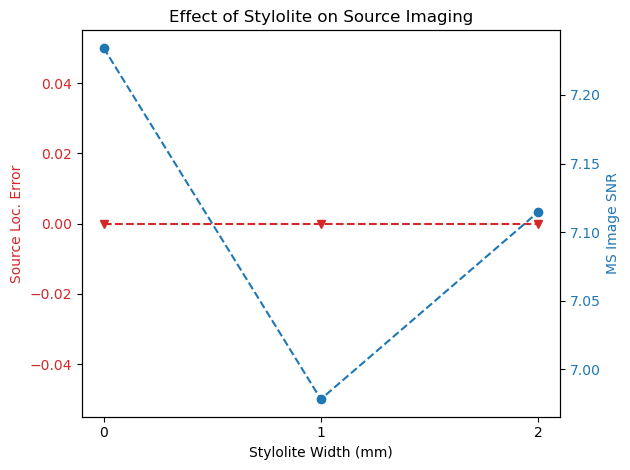

In [21]:
# Create some mock data
t = range(3)
data1 = [0, 0, 0]
data2 = [0.1606/0.0222,
         0.1612/0.0231,
         0.1615/0.0227,
        ]


fig, ax1 = plt.subplots()
ax1.set_xticks([0,1,2],labels=[0,1,2])
ax1.set_xlabel('Stylolite Width (mm)')

color = 'tab:red'
ax1.set_ylabel('Source Loc. Error', color=color)
ax1.plot(t, data1, '--v', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('MS Image SNR', color=color)  # we already handled the x-label with ax1
ax2.plot(t, data2, '--o', color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Effect of Stylolite on Source Imaging')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()